In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation="relu")
        self.dense2 = tf.keras.layers.Dense(64, activation="relu")
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dense3 = tf.keras.layers.Dense(64, activation="relu")
        self.dense4 = tf.keras.layers.Dense(1, activation="relu")

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dropout1(x)
        x = self.dense3(x)
        return self.dense4(x)

In [3]:
def min_max(x):
    min_value = x.min()
    max_value = x.max()
    result = (x - min_value) / (max_value - min_value)
    return result

In [4]:
IN_FILE = "../data/raw/OnlineNewsPopularity/OnlineNewsPopularity.csv"
df = pd.read_csv(IN_FILE, header=0, index_col=None, skipinitialspace=True, engine='python')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [5]:
cols = ['timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']

In [6]:
def create_feature(df):
    feature = df[cols]
    feature = feature.apply(min_max)
    return feature

In [7]:
X = create_feature(df).values
Y = df["shares"].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=9644, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=5000, random_state=0)

In [8]:
model = MLP()
tensorboard = TensorBoard(log_dir="logs")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoint/MLP-{epoch:04d}.ckpt",
    verbose=10,
    save_weights_only=True,
    save_freq=5000
)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    loss="mean_absolute_percentage_error",
    metrics=["mean_absolute_percentage_error", "mean_absolute_error", "mean_squared_error"]
)

In [10]:
losses = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    callbacks=[tensorboard, checkpoint]
)

Train on 25000 samples, validate on 5000 samples
Epoch 1/10
  512/25000 [..............................] - ETA: 23s - loss: 99.9999 - mean_absolute_percentage_error: 99.9999 - mean_absolute_error: 4066.8950 - mean_squared_error: 453111168.0000
Epoch 00001: saving model to ./checkpoint/MLP-0001.ckpt
 9728/25000 [==========>...................] - ETA: 0s - loss: 99.9382 - mean_absolute_percentage_error: 99.9382 - mean_absolute_error: 3578.1460 - mean_squared_error: 189409200.0000
Epoch 00001: saving model to ./checkpoint/MLP-0001.ckpt
12800/25000 [==============>...............] - ETA: 0s - loss: 99.8977 - mean_absolute_percentage_error: 99.8977 - mean_absolute_error: 3462.5388 - mean_squared_error: 157391680.0000
Epoch 00001: saving model to ./checkpoint/MLP-0001.ckpt
18432/25000 [=====================>........] - ETA: 0s - loss: 99.7646 - mean_absolute_percentage_error: 99.7646 - mean_absolute_error: 3411.0459 - mean_squared_error: 137976448.0000
Epoch 00001: saving model to ./checkpoi

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[58.477800950723186, 58.477818, 2434.8699, 78970450.0]


In [12]:
def plot_history_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

def plot_history_mape(fit):
    axR.plot(fit.history['mean_absolute_percentage_error'],label="MAPE for training")
    axR.plot(fit.history['val_mean_absolute_percentage_error'],label="MAPE for validation")
    axR.set_title('model MAPE')
    axR.set_xlabel('epoch')
    axR.set_ylabel('MAPE [%]')
    axR.legend(loc='upper right')

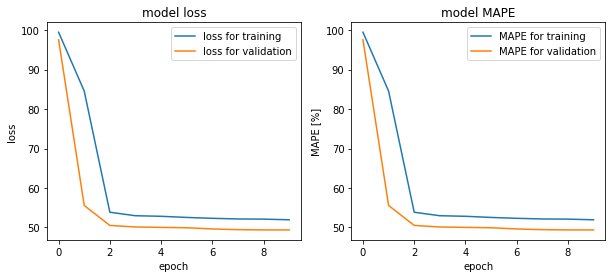

In [13]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
plot_history_loss(losses)
plot_history_mape(losses)